In [3]:
## 分析为什么集成学习比单个学习器要好？

from scipy.misc import comb #计算组合数
import math

def ensemble_error(n_classifier,error):
    k_start = math.ceil(n_classifier/2.0) #统计多少个分类器
    probs = [comb(n_classifier,k) *
            error**k *
            (1-error)**(n_classifier-k)
            for k in range(k_start,n_classifier+1)]
    return sum(probs)

ensemble_error(n_classifier=11,error=0.25)

0.034327507019042969

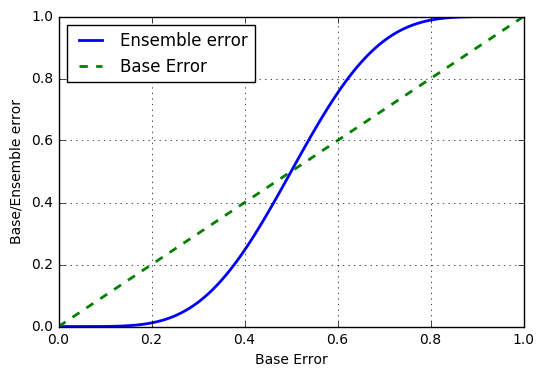

In [5]:
import numpy as np
error_range = np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier=11,error=error) for error
             in error_range]
import matplotlib.pyplot as plt
plt.plot(error_range,ens_errors,
        label='Ensemble error',
        linewidth=2)
plt.plot(error_range,error_range,
        label='Base Error',
        linestyle='--',
        linewidth=2)
plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='best')
plt.grid()
plt.show()

In [11]:
import numpy as np
ex = np.array([[0.9,0.1],
             [0.8,0.2],
             [0.4,0.6]])

p = np.average(ex,axis=0,weights=[0.2,0.2,0.6])
print(np.argmax(p))

0


In [13]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,ClassifierMixin):
    
    def __init__(self,classifiers,vote='classlabel',weights=None):
        self.classifiers= classifiers
        self.named_classifiers = {key:value for key,value in
                                 _name_estimators(classifiers)}
        
        self.vote = vote
        self.weights = weights
    
    def fit(self,X,y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_=[]
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self,X):
        if self.vote  == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in
                                     self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x:np.argmax(np.bincount(x,
                                                                         weights=self.weights)),
                                          axis=1,
                                          arr=predictions)
            
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    
    def predict_proba(self,X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probda,axis=0,weights=self.weights)
        return avg_proba
    
    def get_params(self,deep=True):
        if not deep:
            return super(MajorityVoteClassifier,self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name,step in\
                six.iteritems(self.named_classifiers):
                    for key,value in six.iteritems(step.get_params(deep=True)):
                        out['%s__%s' % (name,key)] = value
            return out